The following analysis aims to understand the impact of failures of active validators to timely upgrade to the Delphi protocol version on Tezos network.  

We applied the following assumptions to the analysis:
(1) Bakers that failed to endorse more than two slots and did not recover from the failure within two hours of the upgrade were considered as impacted by the upgrade.
(2) Active bakers were calculated as the total number of bakers who had endorsing rights in the five cycles immediately after the upgrade (cycles 296..300) and were active in the network with average reliability of 20% or higher before the upgrade.
(3) Bakers who had an average reliability of less than 20% during the four cycles before the upgrade were excluded from the analysis.
(4) Bakers who started their operations in the cycle that followed the upgrade were excluded from the analysis.
(5) The analysis only considered data for the four cycles before the upgrade and five cycles after the upgrade.

In [1]:
import requests
import json
import datetime

# Function to convert datetime in milliseconds to human readable format
def convert_from_ms( milliseconds ): 
    seconds, milliseconds = divmod(milliseconds,1000) 
    minutes, seconds = divmod(seconds, 60) 
    hours, minutes = divmod(minutes, 60) 
    days, hours = divmod(hours, 24) 
    seconds = seconds + milliseconds/1000 
    return round(((days*24*60+hours*60+minutes)/60),2)

# Upgrade cycle parameters 
cycle_upgrade = 296
cycle_before_upgrade_range = [
    cycle_upgrade-4,
    cycle_upgrade-3,
    cycle_upgrade-2,
    cycle_upgrade-1
    ]
cycle_rights_upgrade_range = [
    cycle_upgrade,
    cycle_upgrade+1,
    cycle_upgrade+2,
    cycle_upgrade+3,
    cycle_upgrade+4,
    ]
cycle_upgrade_range = [
    cycle_upgrade-4,
    cycle_upgrade-3,
    cycle_upgrade-2,
    cycle_upgrade-1,
    cycle_upgrade,
    cycle_upgrade+1,
    cycle_upgrade+2,
    cycle_upgrade+3,
    cycle_upgrade+4
]

In [2]:
# Get upgrade block start height and datetime and end block height, timedate
cycle_json = requests.get("https://api.tzstats.com/explorer/cycle/%s" % cycle_upgrade)
cycle = cycle_json.json()
cycle_start_height = cycle.get("start_height")
cycle_start_datetime = cycle.get("start_time")
cycle_start_datetime = datetime.datetime.strptime(cycle_start_datetime, '%Y-%m-%dT%H:%M:%fZ')
cycle_start_datetime = int((cycle_start_datetime - datetime.datetime(1970, 1, 1)).total_seconds()*1000)

In [3]:
# Call Income table API to retrieve metrics per cycle per baker
income_dict = {}
for cycle_income in cycle_upgrade_range:
    income_json = requests.get("https://api.tzstats.com/tables/income?&columns=cycle,address,row_id,rolls,n_delegations,contribution_percent,n_blocks_baked,n_blocks_lost,n_slots_endorsed,n_slots_missed,fees_income,n_baking_rights,n_endorsing_rights,balance,delegated,missed_baking_income,missed_endorsing_income&cycle=%s" % cycle_income)
    income = income_json.json()
    for baker in income:
        if baker[1] not in income_dict:
            income_dict[baker[1]]={}
        income_dict[baker[1]][int(baker[0])]={
            "rolls":baker[3],
            "n_delegations":baker[4],
            "contribution_percent":baker[5],
            "n_blocks_baked":baker[6],
            "n_blocks_lost":baker[7],
            "n_slots_endorsed":baker[8],
            "n_slots_missed":baker[9],
            "fees_income":baker[10],
            "n_baking_rights":baker[11],
            "n_endorsing_rights":baker[12],
            "baker_balance":baker[13], #A baker’s own balance, composed of spendable balance and frozen deposits plus frozen fees (at snapshot block). Note that frozen rewards do not contribute towards rolls, hence they are not part of balance here.
            "delegated_balance":baker[14], #Delegated balance (at snapshot block).
            "missed_baking_income":baker[15],
            "missed_endorsing_income":baker[16]
            }

In [4]:
# Call Rigths API to retrive blocks stats within selected cycle
def query_all_api_rows(cycle):
    rights = []
    cursor = 0
    while True:
        current_row_json = requests.get("https://api.tzstats.com/tables/rights?cycle=%s&type=endorsing&columns=address,height,is_missed,time,priority,cycle,type,row_id&cursor=%s&limit=500000" %(cycle,cursor))
        current_row = current_row_json.json()
        if current_row == []:
            break
        rights.extend(current_row)
        cursor = current_row[-1][7]
    return rights

baker_dict = {}
for cycle in cycle_rights_upgrade_range:
    rights = query_all_api_rows(cycle)
    for right in rights:
        if right[0] not in baker_dict:
            baker_dict[right[0]] = {}
        if int(right[1]) not in baker_dict[right[0]]:
            baker_dict[right[0]][int(right[1])] = {}
        baker_dict[right[0]][int(right[1])][right[4]] = {
            "cycle":right[5],
            "success":(True if right[2] == 0 else False),
            "datetime":right[3]}

In [5]:
#Determine total number of lost blocks and missed endorsements during the five cycles after the upgrade
total_endorsements ={baker_k: 
    {'total_blocks_endorsed':len(baker_v), 
    'total_slots_endorsed':sum([ len(slot.keys()) 
    for slot in baker_v.values()])} 
    for (baker_k,baker_v) in baker_dict.items()
    }

In [6]:
# Create a dictionary for baker realiability per cycle
cycle_reliability_upgrade = {
    baker_k: {
        cycle_k: cycle_v['contribution_percent'] for cycle_k, cycle_v in baker_v.items()
        } for baker_k,baker_v in income_dict.items()}
cycle_reliability_upgrade = { k:v for k,v in cycle_reliability_upgrade.items() if v != {}}

# Calculate average reliability per baker for the three cycles immediately before the upgrade cycle
cycle_reliability_before_upgrade_dict = {}
for baker_key, baker_val in cycle_reliability_upgrade.items():
    contributions_before_upgrade = [ baker_val[cycle_before_upgrade] for cycle_before_upgrade in cycle_before_upgrade_range if cycle_before_upgrade in baker_val and income_dict[baker_key][cycle_before_upgrade]['n_baking_rights']+income_dict[baker_key][cycle_before_upgrade]['n_endorsing_rights']!=0]
    if len(contributions_before_upgrade)>0:
        average_contribution_before_upgrade = round(sum(contributions_before_upgrade) / len(contributions_before_upgrade),2)
        if average_contribution_before_upgrade > 20:
            cycle_reliability_before_upgrade_dict[baker_key] = average_contribution_before_upgrade

In [7]:
#Get private vs public attribute for bakers
account_json = requests.get("https://api.tzkt.io/v1/delegates/?select=address,alias,balance&limit=10000")
is_baker_public ={account['address']:(account['alias'] != None) for account in account_json.json()}

In [8]:
#Analyse correlation between voting and succesful upgrade of the operations to a new protocol
#Delphi: proposal_id = 8
ballots_json = requests.get("https://api.tzstats.com/tables/ballot?proposal_id=8")
baker_ballot_dict = {ballot[11]:True for ballot in ballots_json.json() if ballot[4]=='promotion_vote'}

In [9]:
# Populate upgrade reliability results per baker in a separate dictionary
upgrade_results = {}
count_bakers_more_than_cycle_to_fix = 0
for baker_key in cycle_reliability_before_upgrade_dict.keys():
    if baker_key in baker_dict:
        baker_val = baker_dict[baker_key]
        time_first_success = 0
        first_success = 0
        upgrade_failures = 0 
        upgrade_results[baker_key] = {
                'public':is_baker_public[baker_key],
                'rolls_upgrade_cycle':income_dict[baker_key][cycle_upgrade]['rolls'] if cycle_upgrade in income_dict[baker_key] else 0,
                'baker_balance':income_dict[baker_key][cycle_upgrade]['baker_balance'] if cycle_upgrade in income_dict[baker_key] else 0,
                'delegated_balance':income_dict[baker_key][cycle_upgrade]['delegated_balance'] if cycle_upgrade in income_dict[baker_key] else 0,
                'delegations_upgrade_cycle':income_dict[baker_key][cycle_upgrade]['n_delegations'] if cycle_upgrade in income_dict[baker_key] else 0,
                'avg_contribution_before_upgrade':cycle_reliability_before_upgrade_dict[baker_key],
                'n_rights_upgrade_cycle':(income_dict[baker_key][cycle_upgrade]['n_baking_rights']+income_dict[baker_key][cycle_upgrade]['n_endorsing_rights']) if cycle_upgrade in income_dict[baker_key] else 0,
                'contribution_upgrade_cycle':( cycle_reliability_upgrade[baker_key][cycle_upgrade] if income_dict[baker_key][cycle_upgrade]['n_baking_rights']+income_dict[baker_key][cycle_upgrade]['n_endorsing_rights']!=0 else 0) if cycle_upgrade in income_dict[baker_key] else 0,
                'n_slots_missed_due_to_upgrade_issues':0, #after the upgrade until the first successful bake or until the end of upgrade_cycle+4
                'total_slots_endorsed':total_endorsements[baker_key]['total_slots_endorsed'], #in upgrade cycle and 4 cycles after the upgrade
                'total_blocks_endorsed':total_endorsements[baker_key]['total_blocks_endorsed'], #in upgrade cycle and 4 cycles after the upgrade   
                'last_block_failed_to_endorse':0,
                'first_successful_block':0, 
                'time_to_fix_hours':0,  
                'voted': baker_ballot_dict[baker_key] if baker_key in baker_ballot_dict.keys() else False,
                'upgrade_ready': True
                }
        for height in sorted(baker_val.keys()):
# bakers who failed to bake the first block after the upgrade
            if next(iter(baker_val[height].values()))['success']==True:
                time_first_success = next(iter(baker_val[height].values()))["datetime"]
                first_success = height  
                upgrade_results[baker_key].update({'first_successful_block': first_success})
                break
            else:
                upgrade_failures += 1
                max_failure = height
                time_last_failure = next(iter(baker_val[max_failure].values()))["datetime"]
        if upgrade_failures > 1 and (cycle_upgrade in income_dict[baker_key]):
            time_to_fix = convert_from_ms(time_first_success - cycle_start_datetime)
            upgrade_results[baker_key].update({'last_block_failed_to_endorse': max_failure})
            upgrade_results[baker_key].update({'time_to_fix_hours':time_to_fix})
            upgrade_results[baker_key].update({'n_slots_missed_due_to_upgrade_issues':upgrade_failures}) #after the upgrade until the first successful bake or until the end of upgrade_cycle+4
            if time_to_fix<0 or time_to_fix>2:
                upgrade_results[baker_key].update({'upgrade_ready':False})

In [10]:
#Organize upgrade results in a table compatible with Pandas DataFrame
upgrade_results_pn = {'address':[],
                      'public':[],
                      'rolls_upgrade_cycle':[],
                      'baker_balance':[],
                      'delegated_balance':[], 
                      'delegations_upgrade_cycle':[],
                      'n_rights_upgrade_cycle':[],
                      'avg_contribution_before_upgrade':[],
                      'contribution_upgrade_cycle':[],
                      'n_slots_missed_due_to_upgrade_issues':[],
                      'total_slots':[],
                      'total_blocks':[],
                      'last_block_failed_to_endorse':[],
                      'first_successful_block':[],
                      'time_to_fix_hours':[],
                      'voted':[],
                      'upgrade_ready':[]
                       }
# Populate upgrade reliability results per baker in a separate dictionary
for k,v in upgrade_results.items():
    upgrade_results_pn['address'].append(k)
    upgrade_results_pn['public'].append(v['public'])
    upgrade_results_pn['rolls_upgrade_cycle'].append(v['rolls_upgrade_cycle'])
    upgrade_results_pn['baker_balance'].append(v['baker_balance'])
    upgrade_results_pn['delegated_balance'].append(v['delegated_balance'])
    upgrade_results_pn['delegations_upgrade_cycle'].append(v['delegations_upgrade_cycle'])
    upgrade_results_pn['n_rights_upgrade_cycle'].append(v['n_rights_upgrade_cycle'])
    upgrade_results_pn['avg_contribution_before_upgrade'].append(v['avg_contribution_before_upgrade'])
    upgrade_results_pn['contribution_upgrade_cycle'].append(v['contribution_upgrade_cycle'])    
    upgrade_results_pn['n_slots_missed_due_to_upgrade_issues'].append(v['n_slots_missed_due_to_upgrade_issues'])
    upgrade_results_pn['total_slots'].append(v['total_slots_endorsed'])
    upgrade_results_pn['total_blocks'].append(v['total_blocks_endorsed'])
    upgrade_results_pn['last_block_failed_to_endorse'].append(v['last_block_failed_to_endorse'])
    upgrade_results_pn['first_successful_block'].append(v['first_successful_block'])
    upgrade_results_pn['time_to_fix_hours'].append(v['time_to_fix_hours'])
    upgrade_results_pn['voted'].append(v['voted'])
    upgrade_results_pn['upgrade_ready'].append(v['upgrade_ready'])

In [11]:
#Calculate time it took to fix public baker operations after initial failure following the upgrade
bakers_fixed_within_5cycles_public = {
                    'rolls_upgrade_cycle':[],
                    'time_to_fix_hours':[]
                    }
for k,v in upgrade_results.items():
    if  v['time_to_fix_hours']>2 and v['n_slots_missed_due_to_upgrade_issues']>2 and v['public']==True:
        bakers_fixed_within_5cycles_public['rolls_upgrade_cycle'].append(v['rolls_upgrade_cycle'])
        bakers_fixed_within_5cycles_public['time_to_fix_hours'].append(v['time_to_fix_hours']) 

#Calculate time it took to fix private baker operations after initial failure following the upgrade
bakers_fixed_within_5cycles_private = {
                    'rolls_upgrade_cycle':[],
                    'time_to_fix_hours':[]
                    }
for k,v in upgrade_results.items():
    if  v['time_to_fix_hours']>2  and v['n_slots_missed_due_to_upgrade_issues']>2 and v['public']==False:
        bakers_fixed_within_5cycles_private['rolls_upgrade_cycle'].append(v['rolls_upgrade_cycle'])
        bakers_fixed_within_5cycles_private['time_to_fix_hours'].append(v['time_to_fix_hours']) 

In [12]:
#Calculate time it took to fix baker operations for bakers who voted
bakers_voted_dict = {
                    'rolls_upgrade_cycle':[],
                    'time_to_fix_hours':[]
                    }
for k,v in upgrade_results.items():
    if  v['time_to_fix_hours']>=0 and v['voted']==True:
        bakers_voted_dict['rolls_upgrade_cycle'].append(v['rolls_upgrade_cycle'])
        bakers_voted_dict['time_to_fix_hours'].append(v['time_to_fix_hours']) 

#Calculate time it took to fix baker operations for bakers who did not vote
bakers_notvoted_dict = {
                    'rolls_upgrade_cycle':[],
                    'time_to_fix_hours':[]
                    }
for k,v in upgrade_results.items():
    if  v['time_to_fix_hours']>=0 and v['voted']==False:
        bakers_notvoted_dict['rolls_upgrade_cycle'].append(v['rolls_upgrade_cycle'])
        bakers_notvoted_dict['time_to_fix_hours'].append(v['time_to_fix_hours']) 

Reliability comparison before, during and after the upgrade

In [13]:
import pandas as pd
upgrade_results_table = pd.DataFrame(upgrade_results_pn)
bakers_fixed_within_5cycles_public_df = pd.DataFrame(bakers_fixed_within_5cycles_public)
bakers_fixed_within_5cycles_private_df = pd.DataFrame(bakers_fixed_within_5cycles_private)
bakers_voted_dict_df = pd.DataFrame(bakers_voted_dict)
bakers_notvoted_dict_df = pd.DataFrame(bakers_notvoted_dict)

In [14]:
%matplotlib inline

In [15]:
pd.set_option("display.max.columns", None)

In [16]:
# Get total number of bakers impacted by the upgrade
active_bakers = upgrade_results_table.count()["address"]
active_bakers_share = upgrade_results_table.sum()["rolls_upgrade_cycle"]

impacted_bakers = upgrade_results_table[(upgrade_results_table['upgrade_ready']==False)].count()["address"]
impacted_bakers_share = upgrade_results_table[(upgrade_results_table['upgrade_ready']==False)].sum()["rolls_upgrade_cycle"]

ready_bakers = upgrade_results_table[(upgrade_results_table['upgrade_ready']==True)].count()["address"]
ready_bakers_share = upgrade_results_table[(upgrade_results_table['upgrade_ready']==True)].sum()["rolls_upgrade_cycle"]

bakers_cycle_after_upgrade_pn = {'active bakers':[active_bakers,active_bakers_share],
                                 'all %':["{:.2f} %".format(active_bakers/active_bakers*100),"{:.2f} %".format(active_bakers_share/active_bakers_share*100)],
                                 'impacted bakers':[impacted_bakers,impacted_bakers_share],
                                 'impacted %':["{:.2f} %".format(impacted_bakers/active_bakers*100),"{:.2f} %".format(impacted_bakers_share/active_bakers_share*100)],
                                 'upgrade ready bakers':[ready_bakers,ready_bakers_share],
                                 'ready %':["{:.2f} %".format(ready_bakers/active_bakers*100),"{:.2f} %".format(ready_bakers_share/active_bakers_share*100)]}
bakers_cycle_after_upgrade_df = pd.DataFrame(bakers_cycle_after_upgrade_pn)
bakers_cycle_after_upgrade_df.head()

,active bakers,all %,impacted bakers,impacted %,upgrade ready bakers,ready %
0,400,100.00 %,141,35.25 %,259,64.75 %
1,84604,100.00 %,11592,13.70 %,73012,86.30 %


In [17]:
sorted_df = upgrade_results_table.sort_values(by=['time_to_fix_hours','rolls_upgrade_cycle'], ascending=False)
sorted_df.head(10)

,address,public,rolls_upgrade_cycle,baker_balance,delegated_balance,delegations_upgrade_cycle,n_rights_upgrade_cycle,avg_contribution_before_upgrade,contribution_upgrade_cycle,n_slots_missed_due_to_upgrade_issues,total_slots,total_blocks,last_block_failed_to_endorse,first_successful_block,time_to_fix_hours,voted,upgrade_ready
230,tz1P6XUBesrXF2Jp6shmvPqb1M321GKKNcV1,False,2,1.327850e+04,6.499000e+03,3,5,100.00,0.0,10,11,11,1226937,1232619,344.72,False,False
245,tz1KzSC1J9aBxKp7u8TUnpN8L7S65PBRkgdF,True,24,6.621415e+04,1.333933e+05,131,36,95.45,0.0,159,174,174,1231592,1231732,329.87,False,False
148,tz1Qy1zwn1DSapdsHZSNYDqV5CscnUoSkXCo,False,2,1.666300e+04,9.998920e-01,1,4,100.00,0.0,20,22,22,1229743,1231376,323.93,False,False
278,tz1W3fsiqmVhMWCNCDtDiN2ocgw5ywXqiTZY,False,2,1.619539e+04,1.681227e+01,1,3,81.25,0.0,13,15,15,1228944,1231033,318.17,False,False
251,tz1M8C2V7mVatuz6HgZCPd4bEWM2So7DBGu2,False,1,6.636645e+03,1.501246e+03,7,3,100.00,0.0,3,5,5,1214770,1230981,317.30,True,False
380,tz1hFv3r8UPqaNrUeVJLkCyoZVzPGcYSdyxF,False,1,8.884612e+03,0.000000e+00,0,0,100.00,0.0,3,4,4,1225919,1230823,314.65,False,False
326,tz1LoAuaVudj3JJGZkB8n5tApdSNMDKV7gxK,False,1,8.273205e+03,0.000000e+00,0,1,100.00,0.0,4,8,8,1223135,1230101,302.57,False,False
327,tz1NHJkUcjHwSGHviyrk2WzpXk2c9uYMKknD,False,1889,1.496926e+06,1.361511e+07,39,3110,99.65,0.0,8823,14510,10476,1229622,1229624,294.60,False,False
19,tz1e8u2xHd3HK1gzCYzaXQS9NkDB2ghwxFp8,False,15,1.216437e+05,0.000000e+00,0,22,87.17,0.0,101,122,122,1228893,1229151,286.57,False,False
325,tz1UdeKoMJivgqRgRUNzroMwRJYmJY8BtaWe,True,2,1.815377e+04,1.000000e-06,1,1,93.75,0.0,10,19,19,1226422,1228248,271.18,True,False


In [18]:
impacted_bakers_df = pd.DataFrame(upgrade_results_table[(upgrade_results_table['time_to_fix_hours']<0)])

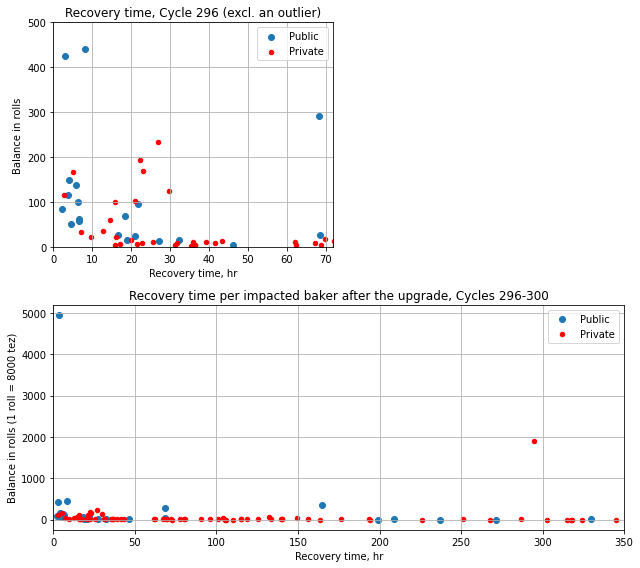

In [19]:
#Recovery time by Public vs Private bakers

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

fig, ax = plt.subplots(figsize=(9, 8))
                       
x1 = bakers_fixed_within_5cycles_public_df.time_to_fix_hours
y1 = bakers_fixed_within_5cycles_public_df.rolls_upgrade_cycle

ax1 = plt.subplot(212)
ax1.margins(0.05)   
ax1.scatter( x1, y1, label='Public')   
ax2 = bakers_fixed_within_5cycles_private_df.plot(kind='scatter', x='time_to_fix_hours', y='rolls_upgrade_cycle', color='red', grid=True, label='Private', ax=ax1)       

ax1 = plt.xlabel('Recovery time, hr')
ax1 = plt.ylabel('Balance in rolls (1 roll = 8000 tez)')
ax1 = plt.title('Recovery time per impacted baker after the upgrade, Cycles 296-300')
ax1 = plt.xlim(left=0, right=350)
plt.legend(('Public','Private'))

#Zoomed in to the cycle_upgrade

ax3 = plt.subplot(221)
ax3.scatter(x1, y1, label='Public')
ax4 = bakers_fixed_within_5cycles_private_df.plot(kind='scatter', x='time_to_fix_hours', y='rolls_upgrade_cycle', color='red', grid=True, label='Private', ax=ax3)       
ax3.set_title('Recovery time, Cycle 296 (excl. an outlier)')
ax3 = plt.legend(('Public','Private'))
ax3 = plt.ylim(top=500,bottom=0)
ax3 = plt.xlim(left=0,right=72)
ax3 = plt.xlabel('Recovery time, hr')
ax3 = plt.ylabel('Balance in rolls')

fig.tight_layout()
plt.show()


In [20]:
baker_rolls_list =[]
income_json = requests.get("https://api.tzstats.com/tables/income?&cycle=%s&columns=rolls&limit=90429" % cycle_upgrade)
income = income_json.json()
for baker_rolls in income:
    baker_rolls_list.append(baker_rolls[0])
num_rolls_cycle_upgrade = sum(baker_rolls_list)

In [21]:
recovery_time_by_wealth = {'recovery_interval':[],'number_of_bakers':[],'number_of_rolls':[],'share_of_total_rolls':[]}

interval_dict = {
                'Upgrade ready':{ k:v for k,v in upgrade_results.items() 
                       if (v['upgrade_ready']==True)},
                '0-3 days':{ k:v for k,v in upgrade_results.items() 
                       if  (v['time_to_fix_hours']>2 and v['time_to_fix_hours']<=72)},
                '3-9 days':{ k:v for k,v in upgrade_results.items() 
                       if  (v['time_to_fix_hours']>72 and v['time_to_fix_hours']<=216)},
                '9-15 days':{ k:v for k,v in upgrade_results.items() 
                       if  (v['time_to_fix_hours']>216 and v['time_to_fix_hours']<=360)},
                 'Over 15 days':{ k:v for k,v in upgrade_results.items() 
                       if  v['time_to_fix_hours']<0}}

for interval_k, interval_v in interval_dict.items():
    recovery_time_by_wealth['recovery_interval'].append(interval_k)
    recovery_time_by_wealth['number_of_bakers'].append(len(interval_v))
    recovery_time_by_wealth['number_of_rolls'].append(sum([ v['rolls_upgrade_cycle'] for v in interval_v.values()]))
    recovery_time_by_wealth['share_of_total_rolls'].append(sum([v['rolls_upgrade_cycle'] for v in interval_v.values()])/num_rolls_cycle_upgrade)

recovery_time_by_wealth_impacted_bakers_df = pd.DataFrame(recovery_time_by_wealth)

total_impacted_bakers = sum(recovery_time_by_wealth['number_of_bakers'])
total_impacted_num_rolls = sum(recovery_time_by_wealth['number_of_rolls'])

In [22]:
#Create DataFrame from recovery_time_by_wealth dictionary
recovery_time_by_wealth_df = pd.DataFrame(recovery_time_by_wealth)

In [23]:
recovery_time_by_wealth_df.head(5)

,recovery_interval,number_of_bakers,number_of_rolls,share_of_total_rolls
0,Upgrade ready,259,73012,0.862730
1,0-3 days,67,8848,0.104550
2,3-9 days,34,674,0.007964
3,9-15 days,14,1946,0.022994
4,Over 15 days,26,124,0.001465


In [24]:
recovery_time_by_vote = {'recovery_interval':[],'number_of_bakers_voted':[],'number_of_bakers_notvoted':[]}

interval_dict_vote = {'Upgrade ready':{ k:v for k,v in upgrade_results.items() 
                       if  ((v['time_to_fix_hours']>=0 and v['time_to_fix_hours']<=2) 
                            and v['voted']==True)},
                        'Impacted':{ k:v for k,v in upgrade_results.items() 
                       if  (((v['time_to_fix_hours']>2 and v['time_to_fix_hours']<=360) or v['time_to_fix_hours']<0)
                             and v['voted']==True)}}

interval_dict_novote = {'Upgrade ready':{ k:v for k,v in upgrade_results.items() 
                       if  ((v['time_to_fix_hours']>=0 and v['time_to_fix_hours']<=2) 
                            and v['voted']==False)},
                        'Impacted':{ k:v for k,v in upgrade_results.items() 
                       if  (((v['time_to_fix_hours']>2 and v['time_to_fix_hours']<=360) or v['time_to_fix_hours']<0)
                             and v['voted']==False)}}

for interval_k, interval_v in interval_dict_vote.items():
    recovery_time_by_vote['recovery_interval'].append(interval_k)
    recovery_time_by_vote['number_of_bakers_voted'].append(len(interval_v))

for interval_k, interval_v in interval_dict_novote.items():
    recovery_time_by_vote['number_of_bakers_notvoted'].append(len(interval_v))

In [25]:
recovery_time_by_vote_df = pd.DataFrame(recovery_time_by_vote)
recovery_time_by_vote_df.head(5)

,recovery_interval,number_of_bakers_voted,number_of_bakers_notvoted
0,Upgrade ready,158,101
1,Impacted,26,115


In [26]:
recovery_time_by_vote = {'recovery_interval':[],'number_of_bakers':[]}

interval_dict_vote = {'Upgrade ready voted':{ k:v for k,v in upgrade_results.items() 
                       if  ((v['time_to_fix_hours']>=0 and v['time_to_fix_hours']<=2) 
                            and v['voted']==True)},
                        'Impacted voted':{ k:v for k,v in upgrade_results.items() 
                       if  (((v['time_to_fix_hours']>2 and v['time_to_fix_hours']<=360) or v['time_to_fix_hours']<0)
                             and v['voted']==True)}}

interval_dict_novote = {'Upgrade ready no vote':{ k:v for k,v in upgrade_results.items() 
                       if  ((v['time_to_fix_hours']>=0 and v['time_to_fix_hours']<=2) 
                            and v['voted']==False)},
                        'Impacted no vote':{ k:v for k,v in upgrade_results.items() 
                       if  (((v['time_to_fix_hours']>2 and v['time_to_fix_hours']<=360) or v['time_to_fix_hours']<0)
                             and v['voted']==False)}}

for interval_k, interval_v in interval_dict_vote.items():
    recovery_time_by_vote['recovery_interval'].append(interval_k)
    recovery_time_by_vote['number_of_bakers'].append(len(interval_v))

for interval_k, interval_v in interval_dict_novote.items():
    recovery_time_by_vote['recovery_interval'].append(interval_k)
    recovery_time_by_vote['number_of_bakers'].append(len(interval_v))

In [27]:
recovery_time_by_vote_df = pd.DataFrame(recovery_time_by_vote)

In [28]:
upgrade_status_dict = {'recovery_interval':[],'number_of_bakers':[]}
interval_dict = {
                'Upgrade ready':{ k:v for k,v in upgrade_results.items() 
                       if  (v['time_to_fix_hours']>=0 and v['time_to_fix_hours']<=2)},
                'Impacted':{ k:v for k,v in upgrade_results.items() 
                       if  ((v['time_to_fix_hours']>2 and v['time_to_fix_hours']<=360) or v['time_to_fix_hours']<0)}}

for interval_k, interval_v in interval_dict.items():
    upgrade_status_dict['recovery_interval'].append(interval_k)
    upgrade_status_dict['number_of_bakers'].append(len(interval_v)) 

upgrade_status_dict_df = pd.DataFrame(upgrade_status_dict)
upgrade_status_dict_df.head(5)

,recovery_interval,number_of_bakers
0,Upgrade ready,259
1,Impacted,141


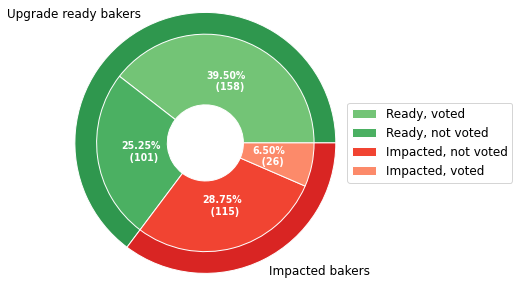

In [29]:
# Upgrade readiness by participation in the upgrade protocol elections
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (9, 5),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))

group_names= ["Upgrade ready bakers","Impacted bakers"]
group_size=upgrade_status_dict_df.number_of_bakers

# Create colors
a, b=[plt.cm.Greens, plt.cm.Reds]
 
# First Ring (outside)
mypie, _ = ax.pie(group_size, radius=1.2, wedgeprops=dict(width=0.5,edgecolor='white'), labels=group_names, colors=[a(0.7), b(0.7)] )

data = [158,101,115,26]
labels = ["Ready, voted","Ready, not voted","Impacted, not voted","Impacted, voted"]

# Create colors
a, b=[plt.cm.Greens, plt.cm.Reds]


def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n  ({v:d})'.format(p=pct,v=val)
    return my_autopct

wedges, texts, autotexts = ax.pie(data, autopct=make_autopct(data),wedgeprops=dict(width=0.65, edgecolor='white'),
                                  textprops=dict(color="w"), colors=[a(0.5), a(0.6), b(0.6), b(0.4)])

ax.legend(wedges, labels,
          loc="center left",
          fontsize=12,
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=9.5, weight="bold")

plt.show()

In [30]:
#Calculate number of missed endorsments and lost blocks 4 cycles before and 5 cycles after the upgrade
income_upgrade_dict = {'cycle':[],
                'n_blocks_lost':[],
                'n_slots_missed':[],
                'n_baking_rights':[],
                'n_endorsing_rights':[],
                'missed_baking_income':[],
                'missed_endorsing_income':[]
                }

for cycle in cycle_upgrade_range:
    income_upgrade_dict['cycle'].append(cycle)
    
    for metric in ['n_blocks_lost', 'n_slots_missed','n_baking_rights','n_endorsing_rights','missed_baking_income','missed_endorsing_income']:
        metric_sum = sum([(baker_v[cycle][metric] if cycle in baker_v else 0) for baker_v in income_dict.values()])
        income_upgrade_dict[metric].append(metric_sum)

income_upgrade_dict_df = pd.DataFrame(income_upgrade_dict)
income_upgrade_dict_df.head(10)

,cycle,n_blocks_lost,n_slots_missed,n_baking_rights,n_endorsing_rights,missed_baking_income,missed_endorsing_income
0,292,31,831,4096,131072,1240.0,1038.75
1,293,47,1174,4096,131072,1880.0,1467.50
2,294,17,756,4096,131072,680.0,945.00
3,295,28,843,4096,131072,1120.0,1053.75
4,296,217,6537,4096,131072,8680.0,8171.25
5,297,143,4556,4096,131072,5720.0,5695.00
6,298,145,3870,4096,131072,5800.0,4837.50
7,299,133,4131,4096,131072,5320.0,5163.75
8,300,40,1507,4096,131072,1600.0,1883.75


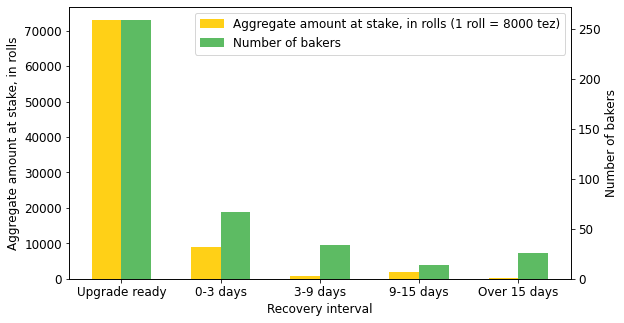

In [31]:
# Upgrade readiness and recovery time per number of bakers and their aggregate tez balance

df = pd.DataFrame({'x' : [1, 2, 3, 4, 5]})
x = df.x

#x= recovery_time_by_wealth_df['recovery_interval']
ax1 = plt.subplot(1,1,1)
w = 0.3
#plt.xticks(), will label the bars on x axis with the respective recovery interval
plt.xticks(x + w /2, recovery_time_by_wealth_df['recovery_interval'])
#plt.xticks(x + w /2, recovery_time_by_wealth_df['recovery_interval'])
#generate bars for Y-left axis for shared X axis
share =ax1.bar(x, recovery_time_by_wealth_df['number_of_rolls'], width=w, color='#FFD017', align='center')
#The trick is to use two different axes that share the same x axis, we have used ax1.twinx() method.
ax2 = ax1.twinx()
#generate bars for Y-right axis for shared X axis
bakers =ax2.bar(x + w, recovery_time_by_wealth_df['number_of_bakers'], width=w,color='#5DBB63',align='center')

#Set the X axis label.
ax1.set_xlabel('Recovery interval')
#Set the Y-left axis label.
ax1.set_ylabel('Aggregate amount at stake, in rolls')
#Set the Y-right axis label.
ax2.set_ylabel('Number of bakers')
#To set the legend on the plot we have used plt.legend()
plt.legend([share, bakers],['Aggregate amount at stake, in rolls (1 roll = 8000 tez)','Number of bakers'])

plt.show()

In [32]:
ready_bakers_share_total = recovery_time_by_wealth_impacted_bakers_df[(recovery_time_by_wealth_impacted_bakers_df.recovery_interval == 'Upgrade ready')].sum()['number_of_rolls']
ready_bakers_total = recovery_time_by_wealth_impacted_bakers_df[(recovery_time_by_wealth_impacted_bakers_df.recovery_interval == 'Upgrade ready')].sum()['number_of_bakers']

impacted_bakers_share_total = recovery_time_by_wealth_impacted_bakers_df[(recovery_time_by_wealth_impacted_bakers_df.recovery_interval != 'Upgrade ready')].sum()['number_of_rolls']
impacted_bakers_total = recovery_time_by_wealth_impacted_bakers_df[(recovery_time_by_wealth_impacted_bakers_df.recovery_interval != 'Upgrade ready')].sum()['number_of_bakers']

impacted_bakers_share_df = (recovery_time_by_wealth_impacted_bakers_df[(recovery_time_by_wealth_impacted_bakers_df.recovery_interval != 'Upgrade ready')]).reset_index(drop = True)

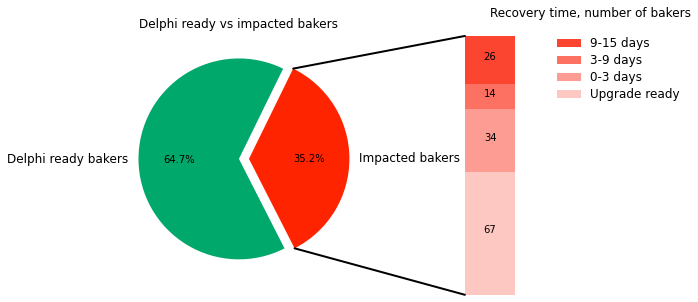

In [33]:
#Pie Chart for recovery_time_by_wealth_df

import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import numpy as np


# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
fig.subplots_adjust(wspace=0)

# pie chart parameters
ratios = [impacted_bakers_total, ready_bakers_total]
labels = ['Impacted bakers', 'Delphi ready bakers']
colors = ['#FF2400','#00A86B']
explode = [0.1, 0]
ax1.pie(ratios, autopct='%1.1f%%', startangle=297, colors=colors,
        labels=labels, explode=explode)
ax1.set_title('Delphi ready vs impacted bakers', horizontalalignment='center')

# bar chart parameters

xpos = 0
bottom = 0
ratios = impacted_bakers_share_df.number_of_bakers
width = 0.2
colors = ['#fec8c2','#fd9c92','#fc7162', '#fc4531']
labels = [recovery_time_by_wealth_impacted_bakers_df.number_of_bakers]

for j in range(len(ratios)):
    height = ratios[j]
    ax2.bar(xpos, height, width, bottom=bottom, color=colors[j])
    ypos = bottom + ax2.patches[j].get_height() / 2
    bottom += height
    ax2.text(xpos, ypos, (ax2.patches[j].get_height()),
             ha='center')


ax2.legend(recovery_time_by_wealth_impacted_bakers_df.recovery_interval,loc='upper right', bbox_to_anchor=(1.3, 0.8),
           labelspacing=-2.5, frameon=False)
ax2.set_title('Recovery time, number of bakers', horizontalalignment='left')
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)


# use ConnectionPatch to draw lines between the two plots
# get the wedge data
theta1, theta2 = ax1.patches[0].theta1, ax1.patches[0].theta2
center, r = ax1.patches[0].center, ax1.patches[0].r
bar_height = sum([item.get_height() for item in ax2.patches])

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(2)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(2)

plt.show()



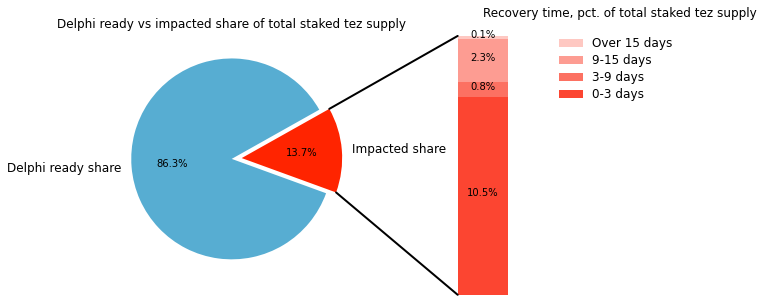

In [34]:
#Pie Chart for recovery_time_by_wealth_df

import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import numpy as np

# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
fig.subplots_adjust(wspace=0)

# pie chart parameters
ratios = [impacted_bakers_share, ready_bakers_share]
labels = ['Impacted share', 'Delphi ready share']
colors = ['#FF2400','#57ADD2']
explode = [0.1, 0]
# rotate so that first wedge is split by the x-axis
#angle = -180 * ratios[0]
ax1.pie(ratios, autopct='%1.1f%%', startangle=340, colors=colors,
        labels=labels, explode=explode)
ax1.set_title('Delphi ready vs impacted share of total staked tez supply', horizontalalignment='center')


# bar chart parameters

xpos = 0
bottom = 0
ratios = impacted_bakers_share_df.share_of_total_rolls #[0.104550,0.007964,0.022994,0.001465]#
width = 0.2
colors = ['#fc4531','#fc7162','#fd9c92','#fec8c2']
labels = [impacted_bakers_share_df.share_of_total_rolls]

for j in range(len(ratios)):
    height = ratios[j]
    ax2.bar(xpos, height, width, bottom=bottom, color=colors[j])
    ypos = bottom + ax2.patches[j].get_height() / 2
    bottom += height
    ax2.text(xpos, ypos, "%0.1f%%" % (ax2.patches[j].get_height() * 100),
             ha='center')

ax2.legend(impacted_bakers_share_df.recovery_interval,loc='upper right', bbox_to_anchor=(1.3, 0.8),
           labelspacing=-2.5, frameon=False)
ax2.set_title('Recovery time, pct. of total staked tez supply', horizontalalignment='left')
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
# get the wedge data
theta1, theta2 = ax1.patches[0].theta1, ax1.patches[0].theta2
center, r = ax1.patches[0].center, ax1.patches[0].r
bar_height = sum([item.get_height() for item in ax2.patches])

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(2)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(2)

plt.show()

In [35]:
income_upgrade_dict = {'cycle':[],
                'n_blocks_lost':[],
                'n_slots_missed':[],
                'n_baking_rights':[],
                'n_endorsing_rights':[],
                'missed_baking_income':[],
                'missed_endorsing_income':[]
                }

for cycle in cycle_upgrade_range:
    income_upgrade_dict['cycle'].append(cycle)
    
    for metric in ['n_blocks_lost', 'n_slots_missed','n_baking_rights','n_endorsing_rights','missed_baking_income','missed_endorsing_income']:
        metric_sum = sum([(baker_v[cycle][metric] if cycle in baker_v else 0) for baker_v in income_dict.values()])
        income_upgrade_dict[metric].append(metric_sum)
    

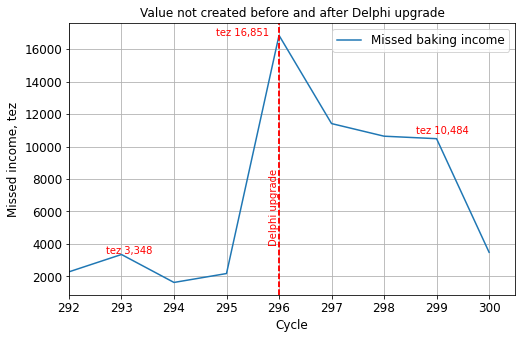

In [38]:
from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8,5)

host = host_subplot(111)
host.set_xlabel("Cycle")
host.set_ylabel("Missed income, tez")

p1, = host.plot(income_upgrade_dict_df.cycle, income_upgrade_dict_df.missed_baking_income+income_upgrade_dict_df.missed_endorsing_income, label="Missed baking income")

leg = plt.legend()

host.yaxis.get_label()
host.set_title('Value not created before and after Delphi upgrade')
x_line_annotation = 296
x_text_annotation = 295.80
host.axvline(x=x_line_annotation, linestyle='dashed', alpha=1, color='red')
host.text(x=x_text_annotation, y=4000, s='Delphi upgrade', alpha=1, rotation='vertical', color='red')

x_line_annotation = 296
x_text_annotation = 294.80
host.axvline(x=x_line_annotation, linestyle='dashed', alpha=1, color='red')
host.text(x=x_text_annotation, y=16851, s='tez 16,851', alpha=1, rotation='horizontal', color='red')

x_text_annotation = 298.6
host.text(x=x_text_annotation, y=10800, s='tez 10,484', alpha=1, rotation='horizontal', color='red')

x_text_annotation = 292.7
host.text(x=x_text_annotation, y=3400, s='tez 3,348', alpha=1, rotation='horizontal', color='red')

plt.xlim(left=292,right=300.5)
host.set_xlim((292,300.5)) 
plt.grid(True)

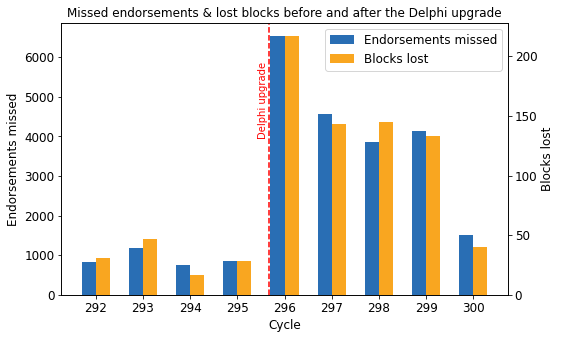

In [39]:
plt.rcParams["figure.figsize"] = (8,5)
x = income_upgrade_dict_df['cycle']
ax1 = plt.subplot(1,1,1)
w = 0.3
#plt.xticks(), will label the bars on x axis with the respective cycle IDs.
plt.xticks(x + w /2, income_upgrade_dict_df['cycle'])
#generate bars for Y-left axis for shared X axis
slots =ax1.bar(x, income_upgrade_dict_df['n_slots_missed'], width=w, color='#296EB4', align='center')
#The trick is to use two different axes that share the same x axis, we have used ax1.twinx() method.
ax2 = ax1.twinx()
#generate bars for Y-right axis for shared X axis
blocks =ax2.bar(x + w, income_upgrade_dict_df['n_blocks_lost'], width=w,color='#F9A620',align='center')
#Set the Graph title.
plt.title('Missed endorsements & lost blocks before and after the Delphi upgrade')
#Set the X axis label.
ax1.set_xlabel('Cycle')
#Set the Y-left axis label.
ax1.set_ylabel('Endorsements missed')
#Set the Y-right axis label.
ax2.set_ylabel('Blocks lost')
#To set the legend on the plot we have used plt.legend()
plt.legend([slots, blocks],['Endorsements missed', 'Blocks lost'])

x_line_annotation = 295.83
x_text_annotation = 295.58
ax1.axvline(x=x_line_annotation, linestyle='dashed', alpha=1, color='red')
ax1.text(x=x_text_annotation, y=4000, s='Delphi upgrade', alpha=1, rotation='vertical', color='red')

plt.show()